# Load packages

In [75]:
#%reset

from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path
import os
from IPython.display import display
from ipyfilechooser import FileChooser
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer
from scipy.stats import zscore
from scipy.interpolate import interp1d
from itertools import groupby
from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer
from ephyviewer import InMemoryAnalogSignalSource
import ephyviewer
import json
%matplotlib widget

from scipy.signal import find_peaks
from scipy.signal import chirp, find_peaks, peak_widths

# Choose OpenEphys folder (to modify)

In [51]:
dpath = "//10.69./.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"
try:
    %store -r dpath
except:
    print("data not in strore")
    dpath ="//10.69./.1/crnldata/waking///L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Select recording folder from OpenEphys</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

# stop when "continuous" & "events" folders appears

FileChooser(path='\\10.69.168.1\crnldata\forgetting\Carla\OpenEphysData\2025-01-31_09-18-34\Record Node 102\ex…

# Load data

In [ ]:
folder = Path(dpath)

# Load metadata 
filepath = os.path.join(folder, f'structure.oebin')
with open(filepath) as f:
    metadata = json.load(f)
samplerate=metadata['continuous'][0]['sample_rate']  
print('sample rate = ', samplerate, 'Hz')
numchannel=metadata['continuous'][0]['num_channels']  
print(numchannel, 'channels recorded')

# Load TTLs
for file_path in folder.glob('**/TTL/timeStamps.npy'):
    print('TTL opto file = ', file_path)
    TTL_Opto = np.load(file_path)
    TTL_Opto= TTL_Opto[::2] # remove the TTL for laser OFF, only keep TTL for laser ON. CAUTION /!\ works only if it started with a TTL for laser ON
    print(TTL_Opto.shape[0], 'opto stimulations')

# Load LFPs 
for file_path in folder.glob('**/continuous.dat'):
    print('LFPs data file = ', file_path)
    LFPs = np.fromfile(file_path, dtype="int16")
    All = LFPs.reshape(-1,numchannel)
    LFPs2 = np.fromfile(file_path, dtype="uint16")
    All2 = LFPs2.reshape(-1,numchannel)
    
# Load LFPs timestamps 
for file_path in folder.glob('**/continuous/*/timeStamps.npy'):
    print('LFPs timestamps file = ', file_path)
    LFPtimestamps = np.load(file_path)  

print(round(All.shape[0]/samplerate/60), 'min of recording')

sample rate =  30000.0 Hz
32 channels recorded
TTL opto file =  \\10.69.168.1\crnldata\forgetting\Carla\OpenEphysData\2025-01-31_09-18-34\Record Node 102\experiment1\recording1\events\OE_FPGA_Acquisition_Board-100.Rhythm Data\TTL\timeStamps.npy
18 opto stimulations
LFPs data file =  \\10.69.168.1\crnldata\forgetting\Carla\OpenEphysData\2025-01-31_09-18-34\Record Node 102\experiment1\recording1\continuous\OE_FPGA_Acquisition_Board-100.Rhythm Data\continuous.dat
LFPs timestamps file =  \\10.69.168.1\crnldata\forgetting\Carla\OpenEphysData\2025-01-31_09-18-34\Record Node 102\experiment1\recording1\continuous\OE_FPGA_Acquisition_Board-100.Rhythm Data\timeStamps.npy
0 min of recording


# Select LFPs channels (to modify)

In [316]:
Channels = '//10.69.168.1/crnldata/waking/audrey_hay/AurelieB/LFPChannels_perMice.xlsx'  # TO MODIFY
mice=folder.parts[-1].split('_')[0] # TO MODIFY
print(mice)

allchannels = pd.read_excel(Channels)

PFCch1=int(allchannels[mice][0].split(',')[0])
PFCch2=int(allchannels[mice][0].split(',')[1])
CA1ch1=int(allchannels[mice][2].split(',')[0])
CA1ch2=int(allchannels[mice][2].split(',')[1])
S1ch1=int(allchannels[mice][1].split(',')[0])
S1ch2=int(allchannels[mice][1].split(',')[1])
EMGch1=int(allchannels[mice][3])

PFC  =  All[:, PFCch1]-All[:, PFCch2] 
CA1  =  All[:, CA1ch1]-All[:, CA1ch2] 
S1  =  All[:, S1ch1]-All[:, S1ch2] 
EMG  =  All2[:, EMGch1]


recording1


KeyError: 'recording1'

### Synchronized TTLs to LFPs start (NOT NEEDED)

In [ ]:
"""A = []
#for file_path in folderMouse.glob('**/*sync_messages.txt'):
file_path= f'{folder}/sync_messages.txt'
with open(file_path, "r") as f:
    lines = f.readlines()
# Loop through all lines, ignoring header.
# take last element to list (i.e. the process name)
    for l in lines[1:]:
        A.append(l.split()[-1])

# remove acquisition frequency that is normally always 25 kHz
initial_OE_start = int(' '.join([x.split('@')[0] for x in A]))
print("Initial start of OE", round(initial_OE_start/samplerate,2), 'sec')

TTL_Opto_n = (TTL_Opto - initial_OE_start/samplerate)
print('Synchronized TTL = ', TTL_Opto_n)
"""

# Get response of each LFPs channels

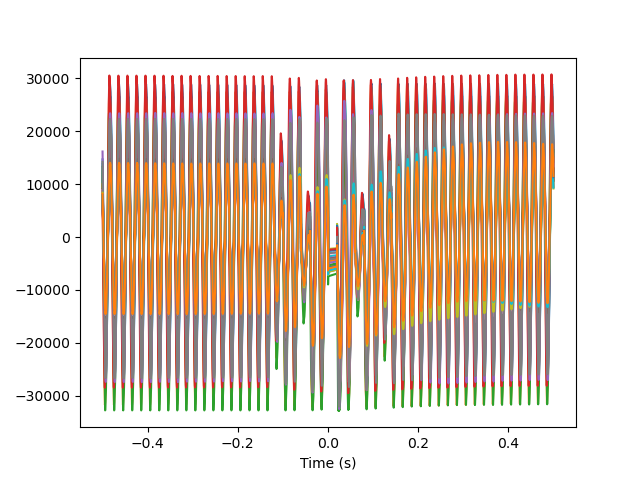

In [329]:
AllEPSPs=[]
for ttl in TTL_Opto:   
    idx = (np.abs(LFPtimestamps - ttl)).argmin() # find the closest LFP timestamps to the TTL
    AllEPSPs.append(All[idx-round(0.5*samplerate):idx+round(0.5*samplerate), :]) #500 ms before and after TTL

plt.close()
time_axis = np.linspace(-0.5, 0.5, np.shape(AllEPSPs)[1]) 
plt.plot(time_axis, np.mean(AllEPSPs,0)) # average stim response of each LFPs channels, ie each color is a LFP channel
plt.xlabel("Time (s)")
plt.show()

# Get response for one LFP

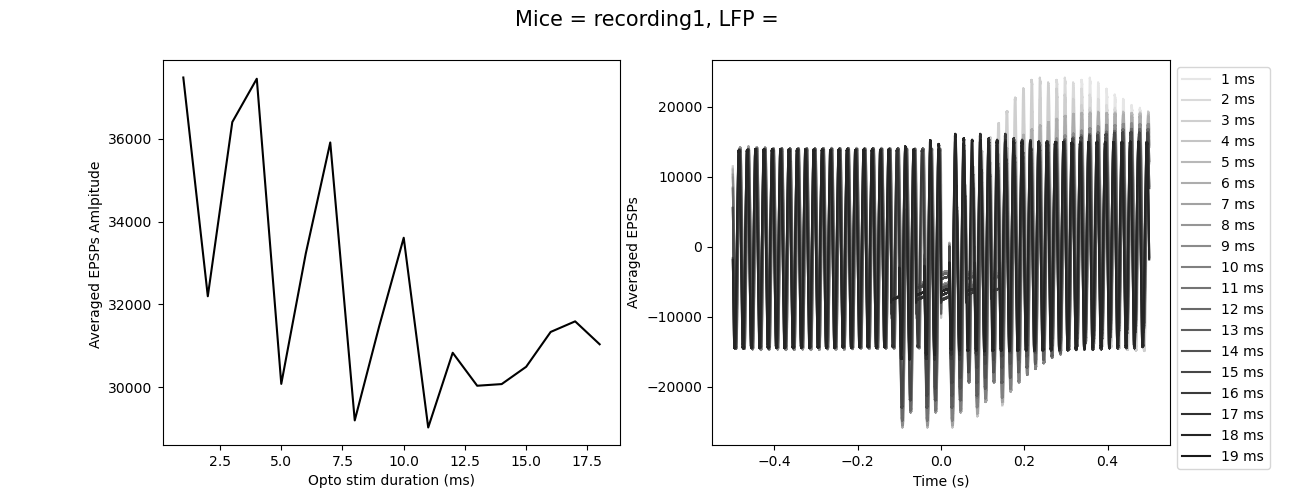

In [334]:
SelectedLFP=All[:,0] # to change for PFC or S1 or etc

nb_differentStim=19 # how many different opto stim are performed in the arduino protocol (here a loop of 19 stim with different durations)
DurationStimArray= np.arange(1,20,1) # durations of each unique stim (from 1 ms to 20 ms with a step of 1)

meanAllStim=pd.DataFrame()
for stim in np.arange(0,nb_differentStim,1):
    StimX=pd.DataFrame()
    for i in np.arange(stim,np.size(TTL_Opto),nb_differentStim):
        idx = (np.abs(LFPtimestamps - TTL_Opto[i])).argmin() # find the closest LFP timestamps to the TTL
        StimX=pd.concat([StimX, pd.DataFrame(SelectedLFP[idx-round(0.5*samplerate):idx+round(0.5*samplerate)])], axis=1) #500 ms before and after TTL
    meanAllStim=pd.concat([meanAllStim, np.mean(StimX, 1)], axis=1)

meanAllStim.columns= DurationStimArray
# Measure amplitude difference 100 ms after stim opto
Amplitude=meanAllStim[round(0.5*samplerate):round(0.6*samplerate)].max()-meanAllStim[round(0.5*samplerate):round(0.6*samplerate)].min()


#Plot
plt.close()
fig, axs = plt.subplots(1,2, figsize=(13,5))
fig.suptitle(f'Mice = {mice}, LFP = ', fontsize=15) # Change to indicate where is located that LFP
axs[0].plot(Amplitude, 'k')
axs[0].set(xlabel="Opto stim duration (ms)", ylabel="Averaged EPSPs Amlpitude ")

time_axis = np.linspace(-0.5, 0.5, meanAllStim.shape[0]) 
grey_shades = np.linspace(0.9, 0.1, len(meanAllStim.columns)) 
for i, col in enumerate(meanAllStim.columns):
    axs[1].plot(time_axis, meanAllStim[col], color=(grey_shades[i], grey_shades[i], grey_shades[i]), label=f'{col} ms')
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axs[1].set(xlabel="Time (s)", ylabel="Averaged EPSPs")
plt.show()
